- Welche Features sollen verwendet werden?
- Standardisierung / Skalierung wie?
- Ziel der Clusteranalyse formulieren

In [1]:
# imports
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


In [3]:
df.shape

(1695041, 23)

In [4]:
df.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew',
       'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [5]:
# Liste der Schadstoffspalten
pollutants = ['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']

# Anteil fehlender Werte pro Spalte
missing_ratios = df[pollutants].isna().mean().sort_values(ascending=True)

print("Anteil fehlender Werte pro Schadstoff:")
print(missing_ratios)


Anteil fehlender Werte pro Schadstoff:
Pm25    0.155129
No2     0.169031
Pm10    0.201828
O3      0.221087
So2     0.314525
Co      0.372833
dtype: float64


In [6]:
# Gruppieren: Für jede Stadt den Mittelwert je Schadstoff berechnen
city_pollution_avg = df.groupby('City')[pollutants].mean()

# Ergebnis prüfen
print(city_pollution_avg.head())


                 Co        No2         O3       Pm10       Pm25       So2
City                                                                     
Abha       5.643478   1.725641  27.278963  11.343590        NaN  2.158371
Abidjan         NaN        NaN        NaN        NaN  69.153588       NaN
Abu dhabi  0.100047  12.198529  27.726151  78.634701  97.833964  4.986937
Accra           NaN        NaN        NaN        NaN  70.522508       NaN
Adana      4.047990  11.321705  16.462533  31.463233  68.214783  4.179630


In [7]:
# Städte mit vollständigen Werten (alle 6 Schadstoffe nicht NaN)
city_pollution_complete = city_pollution_avg.dropna()
print(f"Anzahl Städte mit vollständigen Daten: {city_pollution_complete.shape[0]}")


Anzahl Städte mit vollständigen Daten: 406


In [8]:

# Mittelwerte für Koordinaten je Stadt berechnen
coords = df.groupby('City')[['Latitude', 'Longitude']].mean()

# Nur die Städte mit vollständigen Schadstoffdaten behalten
coords_filtered = coords.loc[city_pollution_complete.index]



In [12]:
import geopandas as gpd
from shapely.geometry import Point

# GeoDataFrame mit Punkt-Geometrie
coords_filtered['geometry'] = coords_filtered.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_complete = gpd.GeoDataFrame(coords_filtered, geometry='geometry', crs='EPSG:4326')


Text(0.5, 1.0, 'Städte mit vollständigen Daten für alle sechs Schadstoffe')

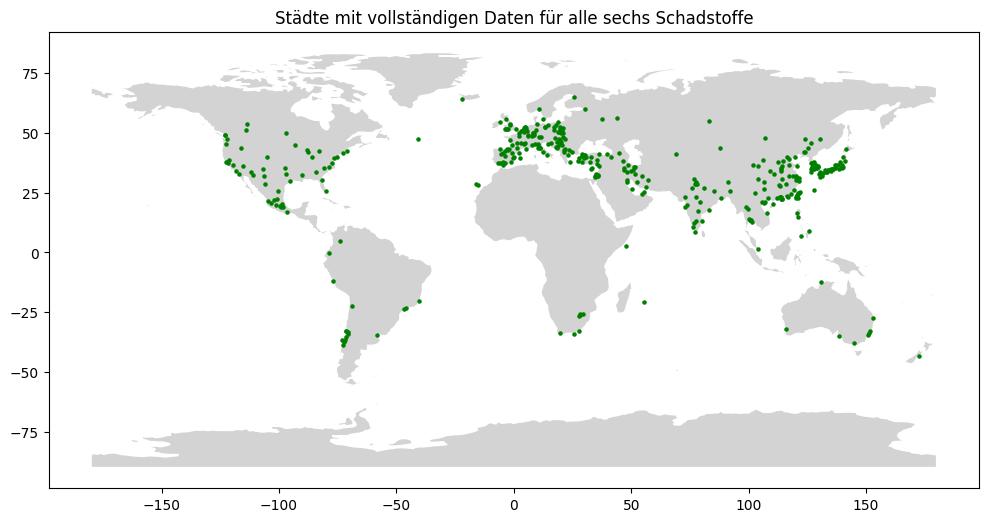

In [15]:
import geodatasets

# Weltkarte laden
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Plot
ax = world.plot(figsize=(12, 6), color='lightgrey', edgecolor='white')
gdf_complete.plot(ax=ax, color='green', markersize=5)

ax.set_title("Städte mit vollständigen Daten für alle sechs Schadstoffe")


In [ ]:
# Daten skalieren, damit die Einheiten der Schadstoffe vergleichbar sind


from sklearn.preprocessing import StandardScaler

# DataFrame mit Schadstoffwerten: city_pollution_complete
# → enthält nur Städte mit vollständigen Werten

# Sicherstellen, dass nur die Werte (nicht die Geo-Spalten) verwendet werden
X = city_pollution_complete.copy()

# Normalisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: In DataFrame umwandeln für bessere Lesbarkeit
import pandas as pd
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

print(X_scaled_df.head())


                      Co       No2        O3      Pm10      Pm25       So2
City                                                                      
Abu dhabi      -0.626870  0.260867  0.849536  2.472179  1.422817  0.046517
Adana          -0.175557  0.116304 -0.422652  0.027760  0.350545 -0.079234
Adapazarı       1.461486  0.342513 -0.542563  0.369139  0.490346  2.329169
Adelaide       -0.358402 -1.448212 -1.620965 -0.913536 -1.516612 -0.273180
Aguascalientes  0.157835 -0.351163 -0.844625  0.315027  0.515283  0.030835


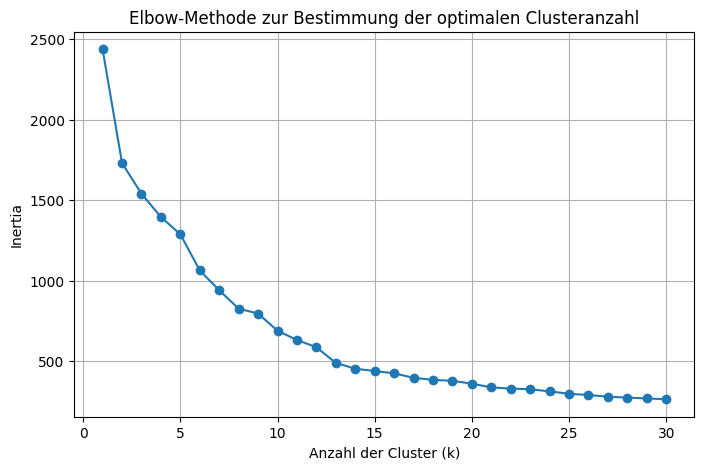

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Für verschiedene Clusterzahlen die "Inertia" berechnen
inertias = []
k_range = range(1, 31)  # z. B. 1 bis 10 Cluster

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot der Elbow-Kurve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung der optimalen Clusteranzahl')
plt.grid(True)
plt.show()


Elbow-Methode nicht eindeutig; es gibt aber ziemlich sicher noch echte Ausreißerstädte, also nehmen wir jetz terst mal 6 Cluster und sehen dann weiter.

In [22]:
# Clustering mit 6 Clustern
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Clusterlabels zum ursprünglichen DataFrame hinzufügen
city_pollution_complete = city_pollution_avg.dropna().copy()
city_pollution_complete['Cluster'] = labels

# Vorschau: Welche Stadt gehört zu welchem Cluster?
print(city_pollution_complete[['Cluster']].value_counts().sort_index())


Cluster
0           73
1          182
2           82
3            1
4           67
5            1
Name: count, dtype: int64


In [23]:
# Beispiel: Cluster 3 hat nur eine Stadt
einzel_clusters = city_pollution_complete['Cluster'].value_counts()
einzel_clusters = einzel_clusters[einzel_clusters == 1].index.tolist()

# Städte aus diesen Clustern anzeigen
einzelstaedte = city_pollution_complete[city_pollution_complete['Cluster'].isin(einzel_clusters)]

print(einzelstaedte.index.tolist())  # Stadt-Namen


['Ashkelon', 'Temuco']


In [24]:
print(einzelstaedte)

                  Co       No2         O3       Pm10       Pm25        So2  \
City                                                                         
Ashkelon  138.725000  4.882136  38.360179  34.591117  58.370522   1.113692   
Temuco      5.965219  6.305758   1.466667  33.199499  67.521637  85.566667   

          Cluster  
City               
Ashkelon        5  
Temuco          3  


## Städte mit extremen Schadstoffprofilen

### Temuco (Chile)
Temuco wurde als Extremfall von der Clusteranalyse ausgeschlossen, da die Stadt durch außergewöhnlich hohe Schwefeldioxid-Werte (SO₂ ≈ 85.6 µg/m³) auffiel, die in keiner anderen Stadt annähernd erreicht wurden. Diese Belastung ist vermutlich auf die Kombination aus häufiger Holzverbrennung im Winter und der Nähe zum aktiven Vulkan Villarrica zurückzuführen. Auch die PM2.5-Werte lagen mit 67.5 µg/m³ deutlich über dem Mittel.

Aufgrund dieses sehr speziellen Luftschadstoffprofils hätte Temuco ein eigenes Cluster gebildet und dadurch die Vergleichbarkeit der übrigen Gruppen verzerrt. Die Stadt wurde daher in der Hauptanalyse ausgeschlossen

### Ashkelon (Israel)
Ashkelon wurde aufgrund technischer Auffälligkeiten ausgeschlossen. Der CO-Wert liegt mit durchschnittlich 138.7 µg/m³ mehr als eine Größenordnung über allen anderen Städten im Datensatz. Auch die übrigen Schadstoffwerte wirken inkonsistent. Die stark abweichenden Werte deuten auf eine defekte oder fehlerhafte CO-Messstation hin.

Um eine Verzerrung der Clusteranalyse durch fehlerhafte Daten zu vermeiden, wurde Ashkelon entfernt. Der Ausschluss erfolgte nicht, um extreme, aber plausible Umweltbedingungen auszublenden, sondern auf Basis der Datenqualität.

In [25]:
# Liste der Städte, die aus der Hauptanalyse entfernt werden:
ausreisser = ['Ashkelon', 'Temuco']

# Neue Version des DataFrames ohne diese beiden
city_pollution_cleaned = city_pollution_complete.drop(index=ausreisser)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
city_pollution_scaled_cleaned = scaler.fit_transform(city_pollution_cleaned)

In [27]:
from sklearn.cluster import KMeans

kmeans_cleaned = KMeans(n_clusters=6, random_state=42)
labels_cleaned = kmeans_cleaned.fit_predict(city_pollution_scaled_cleaned)

# Clusterlabels zum DataFrame hinzufügen
city_pollution_cleaned['Cluster'] = labels_cleaned


In [29]:
city_pollution_cleaned['Cluster'].value_counts().sort_index()


Cluster
0     74
1    181
2      1
3     52
4     16
5     80
Name: count, dtype: int64

In [30]:
# Beispiel: Cluster 3 hat nur eine Stadt
einzel_clusters = city_pollution_cleaned['Cluster'].value_counts()
einzel_clusters = einzel_clusters[einzel_clusters == 1].index.tolist()

# Städte aus diesen Clustern anzeigen
einzelstaedte = city_pollution_cleaned[city_pollution_cleaned['Cluster'].isin(einzel_clusters)]

print(einzelstaedte.index.tolist())  # Stadt-Namen

['Khorramshahr']


In [31]:
print(einzelstaedte)

                     Co        No2          O3       Pm10       Pm25  \
City                                                                   
Khorramshahr  25.591858  35.817337  112.714286  71.874381  91.864452   

                    So2  Cluster  
City                              
Khorramshahr  14.854658        2  


### Khorramshahr (Iran)

Khorramshahr wurde aufgrund seines außergewöhnlich hohen Ozon- und Feinstaubniveaus aus der Hauptclusteranalyse ausgeschlossen. Die Werte deuten nicht auf Messfehler, sondern auf eine ernsthafte Luftbelastung hin, die möglicherweise durch regionale Industrieaktivität, hohe Temperaturen und Photochemie verstärkt wird.

Die Stadt bildet aufgrund ihres Extremprofils ein eigenes Cluster, wodurch die übrige Gruppierung verzerrt würde. Daher wurde sie separat dokumentiert, aber nicht in die finale Clusterstruktur aufgenommen.

In [32]:
# Liste aktualisieren
ausreisser = ['Ashkelon', 'Temuco', 'Khorramshahr']

# Gefilterter DataFrame
X_cleaned_final = city_pollution_complete.drop(index=ausreisser)

In [33]:
scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_cleaned_final)


In [34]:
kmeans_final = KMeans(n_clusters=6, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled_final)

# Clusterlabels hinzufügen
X_cleaned_final['Cluster'] = labels_final


In [35]:
X_cleaned_final['Cluster'].value_counts().sort_index()

Cluster
0     51
1     35
2     17
3     74
4     80
5    146
Name: count, dtype: int64

## Erklärung für Wiebke, warum jetzt PCA
Wir haben sechs Schadstoffe, müssen die aber zweidimensional plotten. Deshalb reduzieren wir die sechs Dimensionen mit einer PCA auf zwei, also X- und Y-Achse. Das hat jetzt nichts mit geografischer Verteilung zu tun, das zeigt nur, wie nah welche Cluster beieinander liegen.

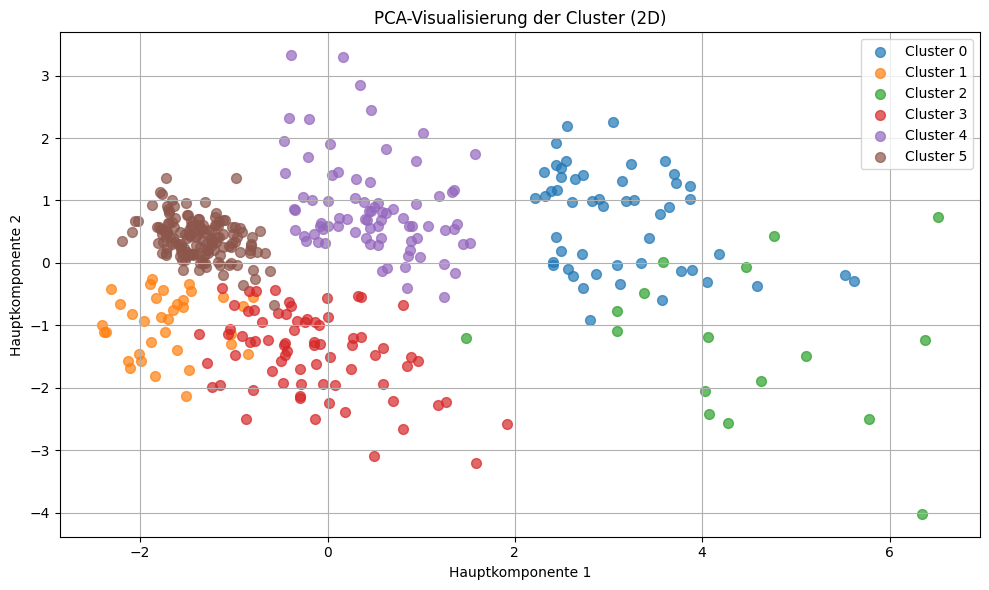

In [36]:
from sklearn.decomposition import PCA

# PCA auf die skalierten Daten anwenden (X_scaled_final aus dem letzten Schritt)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_final)

# In DataFrame mit Clustern zusammenführen
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_cleaned_final.index)
pca_df['Cluster'] = X_cleaned_final['Cluster']

# Farben definieren (automatisch, keine Sorge 😉)
plt.figure(figsize=(10, 6))
for cluster in sorted(pca_df['Cluster'].unique()):
    subset = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', s=50, alpha=0.7)

plt.title("PCA-Visualisierung der Cluster (2D)")
plt.xlabel("Hauptkomponente 1")
plt.ylabel("Hauptkomponente 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📍 Beschreibung der Clusterstruktur (PCA-Visualisierung)

Die nachfolgende PCA-Visualisierung zeigt die Verteilung der Städte im zweidimensionalen Raum, basierend auf ihren durchschnittlichen Schadstoffwerten (CO, NO₂, O₃, PM10, PM2.5, SO₂). Die ursprünglichen sechs Dimensionen wurden mithilfe einer Hauptkomponentenanalyse (PCA) auf zwei Hauptachsen reduziert, die möglichst viel der Varianz im Datensatz abbilden. Die Punkte im Plot repräsentieren einzelne Städte, eingefärbt nach ihrer jeweiligen Clusterzugehörigkeit (KMeans, k=6).

In der linken Hälfte des Plots gruppieren sich die Cluster 1, 3, 4 und 5:

- Cluster 5 erscheint besonders kompakt und dicht, was auf ein sehr homogenes Schadstoffprofil der zugehörigen Städte hindeutet.

- Cluster 1 und Cluster 3 liegen in direkter Nachbarschaft zu Cluster 5 und sind ebenfalls gut erkennbar voneinander abgegrenzt, jedoch weniger dicht. In einem kleinen Bereich überschneiden sich die drei Cluster leicht, was auf gewisse Ähnlichkeiten in den Profilen hindeutet.

- Cluster 4 liegt ebenfalls in der linken Plot-Hälfte, ist jedoch vollständig von den anderen Gruppen abgegrenzt. Die Punktwolke ist weniger dicht, aber klar umrissen, was auf größere interne Varianz, jedoch gute Abgrenzbarkeit hindeutet.

In der rechten Hälfte befinden sich Cluster 0 und Cluster 2:

- Cluster 0 bildet eine kompakte, klar erkennbare Gruppe – möglicherweise mit einem sehr spezifischen Schadstoffmuster.

- Cluster 2 ist das am stärksten gestreute Cluster und wirkt visuell weniger zusammenhängend. Ein einzelner Punkt liegt sogar deutlich entfernt in der linken Plothälfte, nahe bei Cluster 3. Die Zugehörigkeit zu Cluster 2 wird hier nur durch die algorithmische Einfärbung deutlich.

Die Clusterstruktur ist insgesamt gut differenziert und bietet eine fundierte Grundlage für die inhaltliche Analyse der Luftverschmutzungsprofile.

In [37]:
# Mittelwert pro Schadstoff je Cluster

# Mittelwerte der Schadstoffe je Cluster
cluster_profiles = X_cleaned_final.groupby('Cluster')[['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']].mean()

# Optional: auf 2 Dezimalstellen runden für bessere Lesbarkeit
cluster_profiles_rounded = cluster_profiles.round(2)

# Anzeigen
print(cluster_profiles_rounded)


            Co    No2     O3   Pm10    Pm25    So2
Cluster                                           
0         7.22  15.06  19.88  67.51  110.90   6.50
1         2.20   5.34  11.17  15.55   26.91   2.48
2        24.44  24.82  18.20  46.78   63.82  18.70
3         6.70   8.80  12.55  34.82   67.03   6.36
4         5.10  13.39  25.72  33.33   65.71   3.81
5         2.28   7.97  22.94  16.38   38.67   1.99


In [38]:
import geopandas as gpd
from shapely.geometry import Point

# Koordinaten zuordnen
coords = df.groupby('City')[['Latitude', 'Longitude']].mean()

# Nur die bereinigten Städte (ohne Ashkelon, Temuco, Khorramshahr)
coords_final = coords.loc[X_cleaned_final.index]

# GeoDataFrame bauen
coords_final['Cluster'] = X_cleaned_final['Cluster']
coords_final['geometry'] = coords_final.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_final = gpd.GeoDataFrame(coords_final, geometry='geometry', crs='EPSG:4326')


In [48]:
import matplotlib.colors as mcolors

# Eigene 6-Farben-Palette aus 'tab10' extrahieren
custom_cmap = mcolors.ListedColormap(plt.get_cmap("tab10").colors[:6])

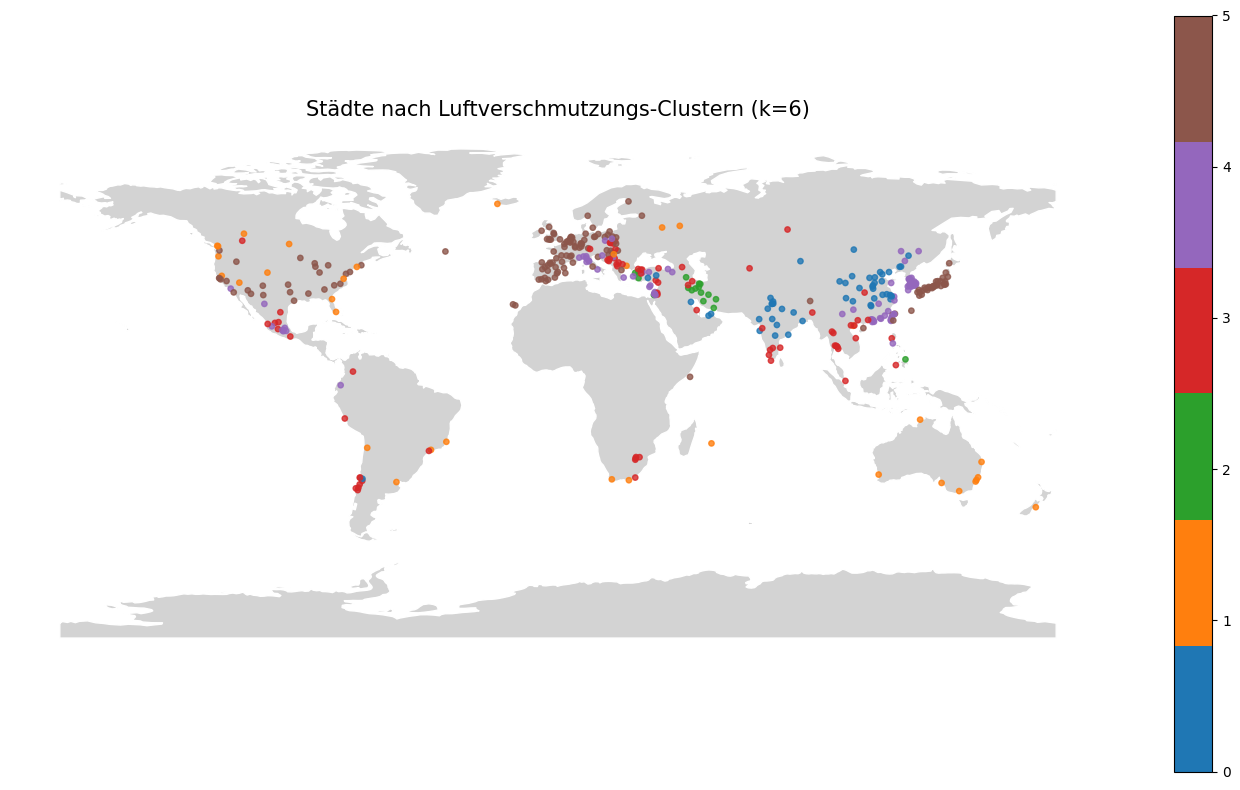

In [51]:
import geodatasets
import matplotlib.pyplot as plt

# Weltkarte laden
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Clusterpunkte plotten
gdf_final.plot(ax=ax, column='Cluster', cmap=custom_cmap, markersize=15, legend=True, alpha=0.8)

# Titel & Layout
ax.set_title("Städte nach Luftverschmutzungs-Clustern (k=6)", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()


Die Clusteranalyse ergibt sechs klar unterscheidbare Luftverschmutzungsprofile:

- Cluster 1 (orange) und 5 (braun) zeigen relativ geringe Schadstoffbelastungen
- Cluster 0 (blau) und 2 (grün) stehen für stark belastete Städte – insbesondere mit hohen Feinstaub-, Stickstoff- und Kohlenmonoxidwerten.
- Cluster 3 (rot) und 4 (lila) nehmen Zwischenpositionen ein, mit jeweils spezifischen Merkmalen: Feinstaubdominanz (Cluster 3) bzw. erhöhte Ozonbelastung (Cluster 4)

Diese Differenzierung erlaubt eine strukturierte Einordnung der Städte nach ihrem Schadstoffprofil und bildet eine solide Grundlage für weiterführende Analysen oder politische Maßnahmen.